# Preprocessing

### Preprocessing steps
0. Remove TrainingScene
1. Blink detection to get true blinks
--> Convert timestampt to seconds
2. Participants must have 11 events, excluding variant 2
3. Steering input should not be constant zero.
4. Large calibration issues (systematic deviations from mean value).
7. Timestamps issues: (1. loong differences from a ts to the next; 2 repeated rows with likely same info)
8. Sampling rate calculation and resample

In [1]:
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63915,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:63927,Total threads: 4
Dashboard: http://127.0.0.1:63928/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:63918,


In [2]:
# Define dtypes to load all uid files
dtypes = {'uid': 'str','dataset': 'str','city_section': 'str','ExperimentalCondition': 'str','EventName': 'object','HitObjectName': 'object','ObjectName_4': 'object','ObjectName_5': 'object', 'EventDuration': 'float64', 'TimeStamp': 'float64'}
# Define the path to the CSV file
# Use the current working directory
dir = os.getcwd()
# Use glob to find all CSV files in the specified directory
data_path = dir + '/Data/'
# file_path = os.path.join(data_folder, file_name)  # Complete path to the file
# load all data
ddf = dd.read_csv(data_path + '*.csv', assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)

In [10]:
# Run only if you want (computer memory permits) to load all csv file 
# df = ddf.compute()

In [6]:
# Get unique uids from the 'uid' column and convert to a list
unique_uids = ddf['uid'].drop_duplicates().compute().tolist()
unique_uids

2025-02-19 00:36:41,386 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6f942101d652dcf820a43442b4e86f6b initialized by task ('shuffle-transfer-6f942101d652dcf820a43442b4e86f6b', 38) executed on worker tcp://127.0.0.1:63926
2025-02-19 00:36:43,680 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6f942101d652dcf820a43442b4e86f6b deactivated due to stimulus 'task-finished-1739921803.680108'


['0117810eb9634c4f98f842021ee6a595',
 '2fe73e7e2534479aa59aeb91635906aa',
 '68dee417b7c6402e80e3001a8d07ac53',
 '7c0436814ca14e00bfab565cb89f4039',
 'a5e665fb970b4b03a810698a63b3b635',
 'e113171c2c8c48679e92a0e241b31060',
 '47e5b0cb9fca4c5c9748b9e03e63a9a7',
 '56341d0729234d90ae05458aab4b43c4',
 '6f36a58eb7d843a593a01191c53bc0d0',
 '9d21c3cf1fb64f87a7ee9f6612d31768',
 '40ffa04f4781418c946b01206562b124',
 '806565e397a2453d8287d04d059399de',
 'a7da330198d5442d92f4cb9a3ab49a62',
 '0121f5b2f59d434f8beb17bf3e2a80b9',
 '228bdb9398f6492092c45467428bb95a',
 '27ee7a0bfc2840e38225f653232d1487',
 '677eb13e053d46edb23876a1cf070e34',
 'f820d1c1117c4255a529f527c6c82d1f',
 '8fa9f3c28edc4b2a88556096f09ec8cb',
 '91519bcefe1844d595ff7317c00b0351',
 '8c3f910d2ca947e9abe0cf5786c40ed3',
 'e204e48fbca64ed9a9aa05a213dc8381',
 'f767840dc9b94eeabb8d0cfb2a5da57c',
 '29006bddb3e8430582165c73bc7af864',
 'b7f065b7dbbe442485552fa041d44b20',
 '0ed7464df24848a68bcc2dfd1ec58f29',
 '5b086469856442e8abac0651c33e2c8e',
 

In [7]:
len(unique_uids)

171

## 0. Remove TrainingScene

In [17]:
# Retrieve all data for specific uid and remove TrainingScene
df = ddf[(ddf['uid'] == unique_uids[0]) & (ddf['city_section'] != 'TrainingScene')].compute()

## 1. Detecting eye blinks
This step we will perform in original dataset with original sampling rate. 
<p> ⚠️Note: <span style="color:orange"> Needs to generalize into a function for all participants.</p>


In [26]:
# Create a condition to detect blinks
# A blink is defined as any entry with all eye position coordinates equal to zero
df['Blink'] = (df['EyePosLocalCombined.x'] == 0) & \
                        (df['EyePosLocalCombined.y'] == 0) & \
                        (df['EyePosLocalCombined.z'] == 0)

In [27]:
df.head(10)

,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,FPS,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,...,SuccessfulCompletionState,HitObjectName,TimeStamp,ReceivedInput,SteeringInput,AcellerationInput,BrakeInput,TimeStamp_in_sec,Blink,BlinkDuration
42855,2020-09-20 12:15:44.588920320+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,429.881805,90.297363,False,False,...,NaN,NaN,1.600604e+09,True,-0.029563,0.0,0.0,158.682380,False,249.878738
42856,2020-09-20 12:15:44.632803328+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.896942,71.465767,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.726263,False,0.000000
42857,2020-09-20 12:15:44.647762944+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.912354,70.750725,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.741222,False,0.000000
42858,2020-09-20 12:15:44.658733568+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.923523,72.263382,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.752193,False,0.000000
42859,2020-09-20 12:15:44.669704448+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.934845,73.604530,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.763164,False,0.000000
42860,2020-09-20 12:15:44.691645696+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.956573,76.495796,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.785105,False,0.000000
42861,2020-09-20 12:15:44.703613952+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.967896,77.528625,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.797073,False,0.000000
42862,2020-09-20 12:15:44.714584064+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,469.979218,78.485138,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.808044,False,0.000000
42863,2020-09-20 12:15:44.735527936+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,470.000977,80.727760,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.828987,False,0.000000
42864,2020-09-20 12:15:44.758997760+00:00,0117810eb9634c4f98f842021ee6a595,EyeTracking,MountainRoad,FullLoopAR,1.600604e+09,470.023468,82.142647,False,False,...,NaN,NaN,1.600604e+09,True,-0.004544,0.0,0.0,158.852457,False,0.000000


In [28]:
# Initialize a column to hold blink duration information
df['BlinkDuration'] = 0

# Calculate blink durations
for uid, group in df.groupby('uid'):
    # Identify where blinks start and end
    blink_starts = group['Blink'] & ~group['Blink'].shift(1).fillna(False)  # Blink starts
    blink_ends = group['Blink'] & ~group['Blink'].shift(-1).fillna(False)    # Blink ends

    # Calculate the durations
    blink_times = group[blink_starts]['TimeStamp_in_sec']
    durations = group[blink_ends]['TimeStamp_in_sec'].reset_index(drop=True) - blink_times.reset_index(drop=True)

    # Update the BlinkDuration column for those indices in the DataFrame
    for start_index, duration in zip(blink_times.index, durations ):
        df.at[start_index, 'BlinkDuration'] = duration

# Filter the DataFrame to retain only the rows where blinks occurred
blinks_df = df[df['BlinkDuration'] > 0]

# Group by uid and sum the blink durations
blink_durations_summary = blinks_df.groupby('uid')['BlinkDuration'].sum().reset_index()

/var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/ipykernel_26291/2726564720.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.12167500800001108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[start_index, 'BlinkDuration'] = duration


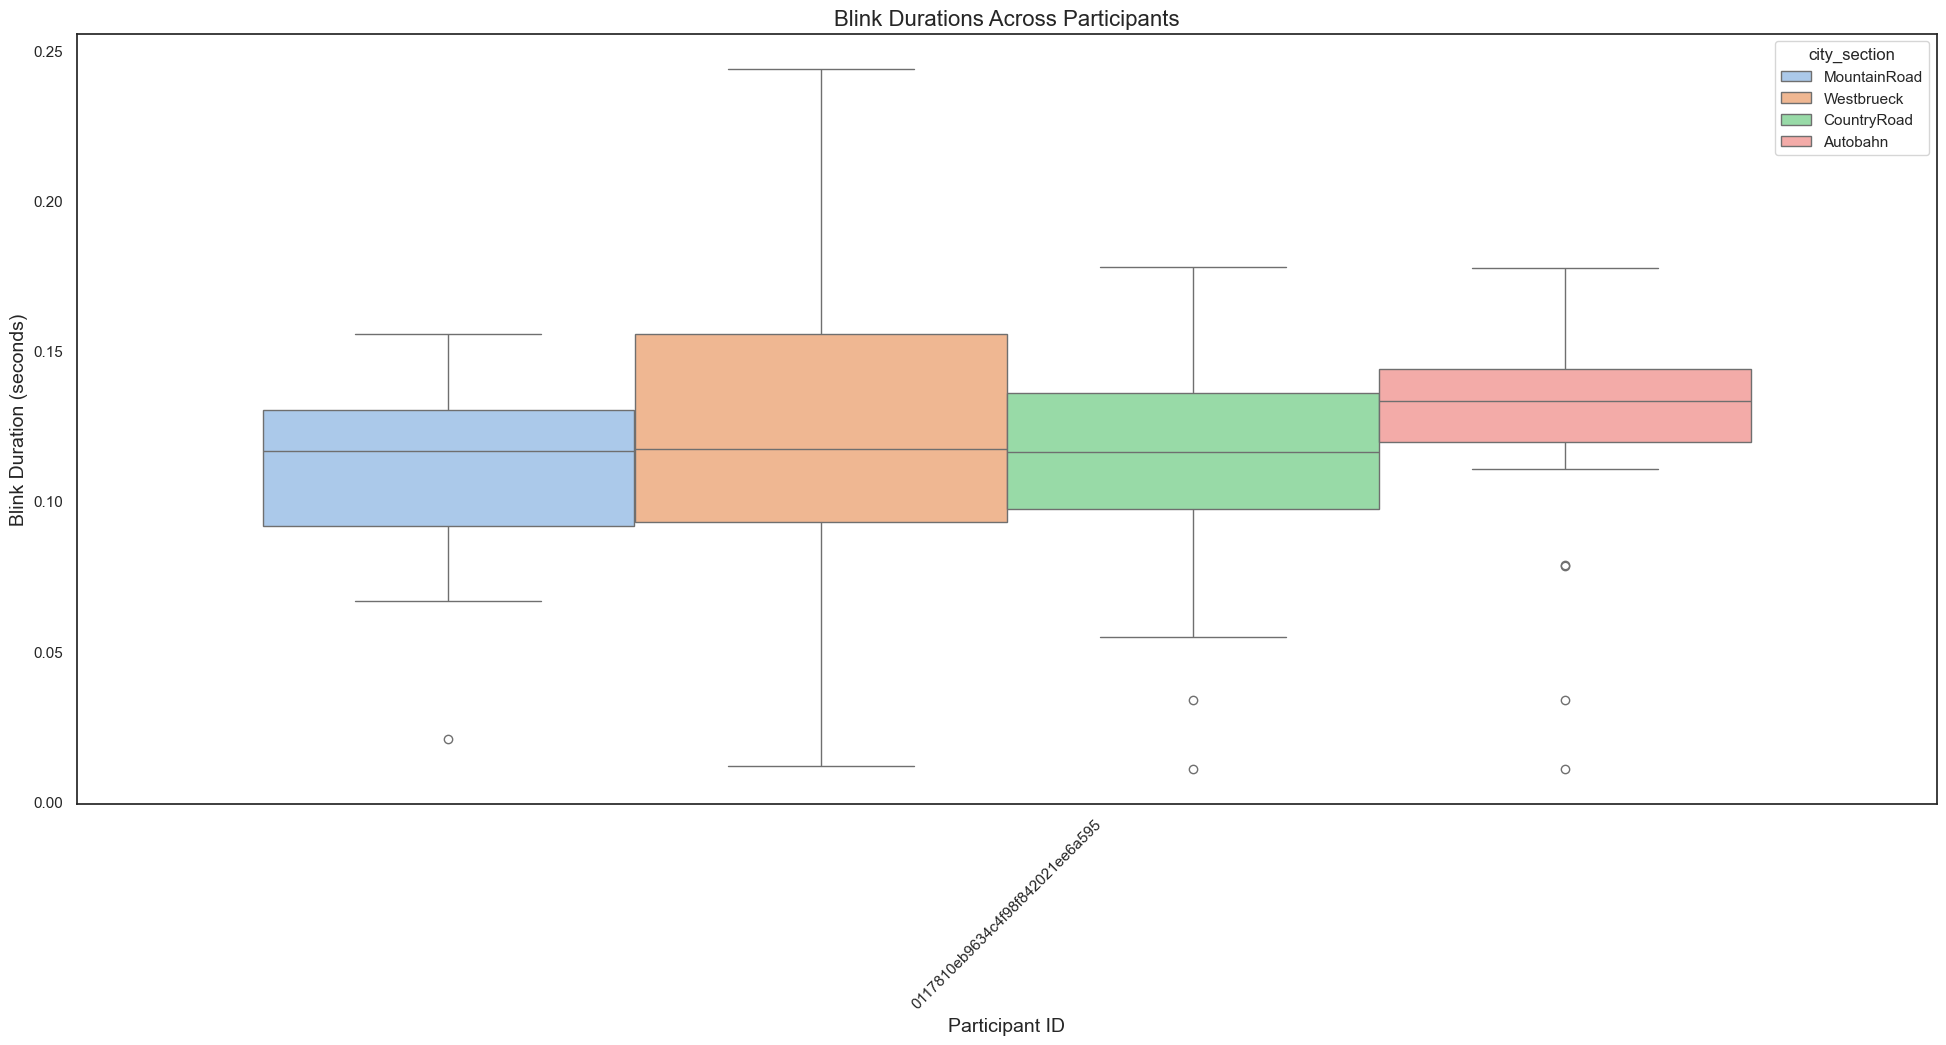

In [29]:
# Set the visual style
sns.set(style="white")

# Create a boxplot for blink durations across participants
plt.figure(figsize=(24, 10))
# fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='uid', y='BlinkDuration', data=blinks_df, hue='city_section', palette='pastel')

# Add title and labels
plt.title('Blink Durations Across Participants', fontsize=16)
plt.xlabel('Participant ID', fontsize=14)
plt.ylabel('Blink Duration (seconds)', fontsize=14)
plt.xticks(rotation=45)
# plt.savefig(f"Plots/blink_durations_across_participants" +'.jpeg', dpi=500, bbox_inches='tight')
plt.show()

### Later steps:
While applying Blink detection and interpolate short durations and exclude long durations (Literature to support > 500ms)